## Quantifying stellar density with MAF data 

In [4]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

In [480]:
# Load up the data, copy the keys into variables
data = np.load('../raw_data/starDensity_r_nside_64.npz')

# the data consists of 
# data['starDensity'],  expressed as stars / sq. deg  ,  per pixel, per magnitude
# data['bins'], defining the magnitude ranges for each of the 65 magnitude bins 
# data['overMaxMask'], which tells where there are more than 1e6 stars 

# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = data['starDensity'].copy()
# magnitude bins 
bins = data['bins'].copy()
# pixels where there were so many  (1e6 ) stars some were skipped
mask = data['overMaxMask'].copy()

In [481]:
#  shape is  pixel number  ,  magnitude bins 
#  display the shape 
data['starDensity'].shape

(49152, 65)

We cut on r  < 24.5, and select $\delta <0$, since we're interested in Southern Hemisphere (LSST , etc )

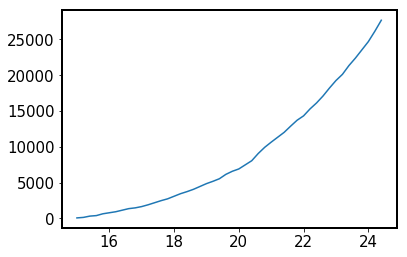

In [482]:
# Confirm that the data along magnitude bins is indeed cumulative ... 
plt.plot( bins[bright_mags], data['starDensity'][:,bright_mags][-1])

In [509]:
np.shape(data['starDensity'][:, bright_mags])

(49152, 48)

array([    0,     1,     2, ..., 49149, 49150, 49151])

### Select pixels r < 24.5,  southern hemisphere

In [483]:
# select only bins with magnitude smaller than 24.5 
bright_mags, = np.where(bins<24.5)
faintest_mag_bin = bright_mags[-1]

# sum all data for number density ... 
#starDensity_lt_245 = np.sum(data['starDensity'][:, bright_mags],axis=1)
starDensity_lt_245 = data['starDensity'][:,faintest_mag_bin]
healpix_number  =  np.arange(len(starDensity_lt_245)) 

# Generate the ra, dec array from healpy
nside = hp.npix2nside(np.size(mask))
lat,ra = hp.pix2ang(nside, np.arange(np.size(mask)))
dec = np.pi/2-lat

# This array has a number of stars per square degree per healpixel
# in the Southern Hemisphere 
# We select only southern pixels... 

# also, convert to degrees from pesky healpix radians ... 
mask_south = dec < 0
dec_sel = np.degrees(np.array(dec[mask_south]))
ra_sel = np.degrees(np.array(ra[mask_south]))           
starDensity_lt_245_sel = starDensity_lt_245[mask_south]
healpix_n_sel = healpix_number[mask_south]

In [401]:
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

### Calculate fraction of sky at higher density : cumulative density 

In [484]:
# Sort by stellar density, and for each pixel, ask how many pixels there is with a density
# greater than that?  

# sorted_px_densities = np.sort(starDensity_lt_245_N)
# record that density 

density_dic = {'N_gt_px':[], 'healpix':[], 'px_density':[],  'ra':[], 'dec':[]}

for i in range(len(starDensity_lt_245_sel)):
    px_density = starDensity_lt_245_sel[i]
    density_dic['px_density'].append(px_density)
    # count the number of pixels with 
    # density greater or equal to that 
    N_gt = np.sum(starDensity_lt_245_sel >= px_density)
    density_dic['N_gt_px'].append(N_gt)
    density_dic['ra'].append(ra_sel[i])
    density_dic['dec'].append(dec_sel[i])
    density_dic['healpix'].append(healpix_n_sel[i])
    
 

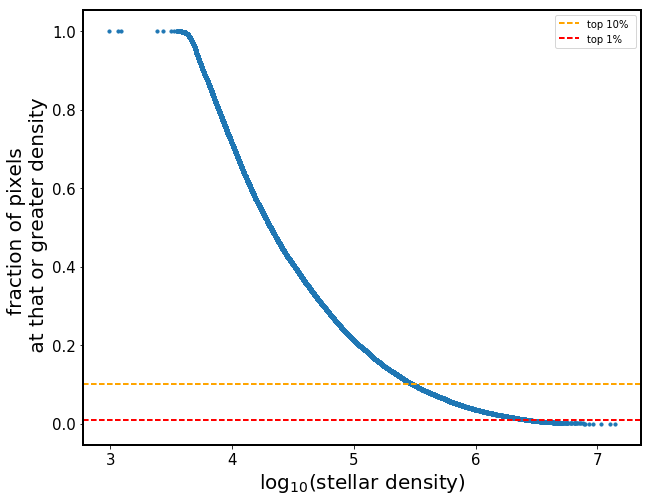

In [485]:
# Illustrate the method 
# of finding 'top1%' pixels...
N_pix = len(density_dic['N_gt_px'])
fig,ax  = plt.subplots(1,1,figsize=(10,8))
ax.scatter( np.log10(np.array(density_dic['px_density'])), 
            np.array(density_dic['N_gt_px']) / N_pix, s=10)
ax.set_ylabel('fraction of pixels \n at that or greater density')
ax.set_xlabel(r'$\log_{10}$'+'(stellar density)')
ax.axhline(0.1, ls='--', lw=2, color='orange', label='top 10% ')
ax.axhline(0.01, ls='--', lw=2, color='red',label='top 1% ')
plt.legend()
plt.savefig('Illustrate_density_percentile.png')

Selection below includes ALL pixels that have density higher than a given level. But to speak of eg. top 10% pixel,  we don't want any pixel that has density in the top 10%,  but those that are eg. between 89-91 percentiles. Otherwise, top 10% includes top5% and top 1% , etc... 

In [420]:
# find indices of  pixels that have stellar density so 
# high that less than 10% 
# of all pixels have that density
top_percentile = 0.05  #  0.01 ,  0.05 , 0.2,  0.5  :  

N_pix = len(density_dic['N_gt_px'])
# find indices 
idx, = np.where((np.array(density_dic['N_gt_px']) / N_pix) < top_percentile)
print('There are %d of pixels in the top %.2f \
percent of the sky density fraction'%(len(idx),100*top_percentile ))

ra_top_perc = np.array(density_dic['ra'])[idx]
dec_top_perc =  np.array(density_dic['dec'])[idx]

There are 1222 of pixels in the top 5.00 percent of the sky density fraction


In [156]:
# Select those between two percentiles ... 


#  0.01 : no need for anything else 
#  0.05:  grab between  0.04 and 0.06  and call these 'top 5% '
#  0.2 : between  0.19 and 0.21 
# 0.5 : between 0.49  and 0.51 

bottom_percentile = 0.04
top_percentile = 0.06

N_pix = len(density_dic['N_gt_px'])
# find indices 
fraction_of_sky_greater = np.array(density_dic['N_gt_px']) / N_pix
idx, = np.where( (bottom_percentile < fraction_of_sky_greater) & 
                (fraction_of_sky_greater < top_percentile) )


print('There are %d of pixels between %.2f and %.2f \
percent of the sky density fraction'%(len(idx),100*bottom_percentile, 
                                      100*top_percentile ))

# Plot pixels between these two percentiles 
# note, coords already in degrees ,,, 
ra_x_perc = np.array(density_dic['ra'])[idx]
dec_x_perc = np.array(density_dic['dec'])[idx]

There are 489 of pixels between 4.00 and 6.00 percent of the sky density fraction


In [38]:
#density_dic['ra']

289.6875 -0.596841830507
288.984375 -1.19374843714
290.390625 -1.19374843714
277.03125 -1.79078465933
278.4375 -1.79078465933
279.84375 -1.79078465933
289.6875 -1.79078465933
283.359375 -2.38801546327
288.984375 -2.38801546327
278.4375 -2.98550600575


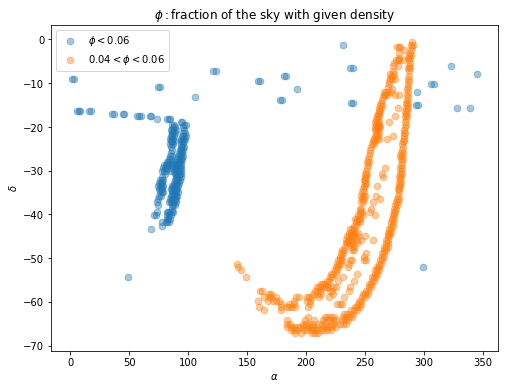

In [157]:


sel = 10
for ra,dec in zip(ra_x_perc[:sel], dec_x_perc[:sel]): 
    print(ra,dec)
    
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(ra_top_perc, dec_top_perc, alpha=0.4,s=44,  
            label=  r'$  \phi  <$'+str(top_percentile))
ax.scatter(ra_x_perc,dec_x_perc, alpha=0.4, s=44, 
            label =str(bottom_percentile)+ r'$< \phi < $'+str(top_percentile))
ax.legend()
ax.set_title(r'$\phi:$' + 'fraction of the sky with given density')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')
plt.savefig('Illustrate_rep_density_regions_5.png', bbox_inches='tight')

There are 244 of pixels in the top 1.00 percent of the sky density fraction
234.84375 -0.596841830507
121.640625 -1.19374843714
321.328125 -1.19374843714
88.59375 -1.79078465933
120.9375 -1.79078465933
122.34375 -1.79078465933
320.625 -1.79078465933
234.140625 -2.38801546327
319.921875 -2.38801546327
122.34375 -2.98550600575


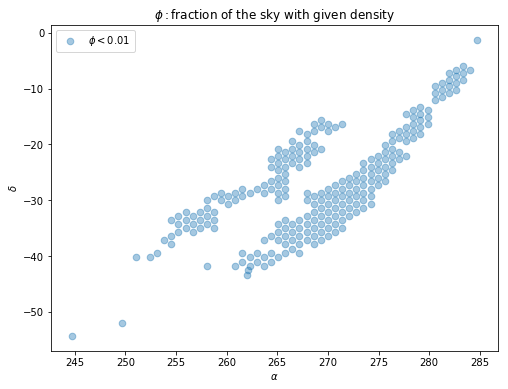

In [176]:
# For top 1% just plot the regions of the sky with that percentage

# find indices of  pixels that have stellar density so 
# high that less than 10% 
# of all pixels have that density
top_percentile = 0.01  #  0.01 ,  0.05 , 0.2,  0.5  :  

N_pix = len(density_dic['N_gt_px'])
# find indices 
idx, = np.where((np.array(density_dic['N_gt_px']) / N_pix) < top_percentile)
print('There are %d of pixels in the top %.2f \
percent of the sky density fraction'%(len(idx),100*top_percentile ))

ra_top_perc = np.array(density_dic['ra'])[idx]
dec_top_perc =  np.array(density_dic['dec'])[idx]

sel = 10
for ra,dec in zip(ra_x_perc[:sel], dec_x_perc[:sel]): 
    print(ra,dec)
    
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(ra_top_perc, dec_top_perc, alpha=0.4,s=44,  
            label=  r'$  \phi  <$'+str(top_percentile))
ax.legend()
ax.set_title(r'$\phi:$' + 'fraction of the sky with given density')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')
plt.savefig('Illustrate_rep_density_regions_1.png', bbox_inches='tight')

### Make the dictionary of pixels representative of different densities 

In [498]:
# Save the ra, dec of regions at example densities into dic ...

N_pix = len(density_dic['N_gt_px'])
fraction_of_sky_greater = np.array(density_dic['N_gt_px']) / N_pix
dic_radec = {}
for bottom_percentile, top_percentile in zip([0, 0.04, 0.19, 0.49],
                                             [0.01, 0.06, 0.21, 0.51]):
    # find indices 
    idx, = np.where( (bottom_percentile < fraction_of_sky_greater) & 
                    (fraction_of_sky_greater < top_percentile) )
    print('There are %d of pixels between %.2f and %.2f \
    percent of the sky density fraction'%(len(idx),100*bottom_percentile, 
                                          100*top_percentile ))

    # Plot pixels between these two percentiles 
    # note, coords already in degrees ,,, 
    ra_x_perc = np.array(density_dic['ra'])[idx]
    dec_x_perc = np.array(density_dic['dec'])[idx]

    dic_radec[top_percentile] = {}
    dic_radec[top_percentile]['ra'] = ra_x_perc
    dic_radec[top_percentile]['dec'] = dec_x_perc
    dic_radec[top_percentile]['N_px_gt_density'] = np.array(density_dic['N_gt_px'])[idx]
    dic_radec[top_percentile]['px_density'] = np.array(density_dic['px_density'])[idx]
    dic_radec[top_percentile]['healpix'] = np.array(density_dic['healpix'])[idx]


There are 244 of pixels between 0.00 and 1.00     percent of the sky density fraction
There are 489 of pixels between 4.00 and 6.00     percent of the sky density fraction
There are 489 of pixels between 19.00 and 21.00     percent of the sky density fraction
There are 481 of pixels between 49.00 and 51.00     percent of the sky density fraction


In [430]:
dic_radec[0.01]

{'N_px_gt_density': array([195, 203, 168, 148, 115, 170, 197, 160, 222, 154, 166, 136, 234,
        179, 157, 184, 224, 216, 138,  62, 212, 101, 134, 103, 163, 135,
        244, 221, 142,  68, 155, 189,  50, 165,  70, 211, 186,  67,  89,
        169, 196, 183,  60, 139, 161, 233, 110, 243, 204, 123, 125, 238,
        146,  81, 117, 182, 102,  20, 141, 122,  66,  55, 206, 150, 215,
        162,  85,  18,  78, 172, 202,  64,  17,  80, 137, 237,  94,  12,
         51,  92,  87, 210, 119,  16,  45, 111, 175,  32, 159,  90, 132,
         23,  54, 128, 230,  69, 152,  36,  72, 190,  61,  57, 200,  26,
         48, 133,  47,   8,  49,  22,  99, 207, 118,  35,   4,  41,   5,
         11,  65, 143, 209, 153,  53,  28,  34,  63,   3,  10,  56, 127,
        235, 131,  52,  98,  46,   2,   7,  42, 112, 158,  74, 106,  24,
          1,   9,  21, 100, 199, 225, 126, 236,   6,  29,  91, 167, 174,
         39,  84, 191, 149,  76,  25,  71, 192, 147, 109, 201,  30,  77,
        185, 187,  95,  93,  44,

0.01
0.06
0.21
0.51


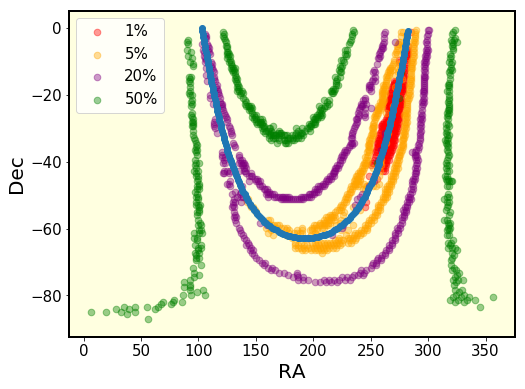

In [541]:
# plot pixels representing each density regime ...
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.set_facecolor('LightYellow')
labels = ['1%','5%', '20%', '50%' ]
colors = ['red', 'orange', 'purple', 'green']
i = 0
for key in dic_radec.keys() : 
    print(key)
    ax.scatter(dic_radec[key]['ra'], dic_radec[key]['dec'], alpha=0.4,s=44,  
            label= labels[i], color=colors[i])
    i += 1 
    
# In  Galactic coordinates,  galaxy lies 
# all around in longitude, 
# at zero latitude
lon = np.arange(0,360)
lat = np.zeros_like(lon)
c_gal = SkyCoord(lon,lat, frame='galactic', unit='deg')

# convert galactic coords to icrs 
ax.scatter(c_gal.icrs.ra[c_gal.icrs.dec.deg<0], 
           c_gal.icrs.dec[c_gal.icrs.dec.deg<0])
plt.legend(fontsize=15)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.savefig('Illustrate_density_regions.png', bbox_inches='tight')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


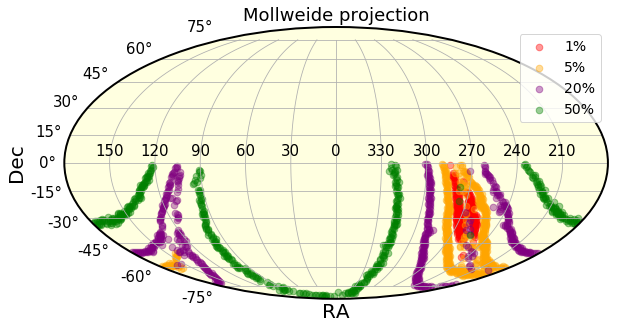

In [542]:
# Plot the same in Mollweide projection...
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow')

origin = 0
i= 0
labels = ['1%','5%', '20%', '50%' ]
for key in dic_radec.keys() : 
    RA=dic_radec[key]['ra']
    Dec = dic_radec[key]['dec']
    
    # possibility to center the map on 0 or 180...
    x = np.remainder(RA+360-origin,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+origin,360)
    
    # plot 
    ax.scatter(np.radians(x),np.radians(Dec),  alpha=0.4,s=44,
               label= labels[i], color = colors[i])  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    i += 1
    
title='Mollweide projection'
ax.set_title(title)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.grid(True)
plt.legend(fontsize=14)
plt.savefig('Illustrate_density_regions_mollw.png', bbox_inches='tight')

Ok , so the ra,dec are different - I still wonder why it does not follow the Milky Way...

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


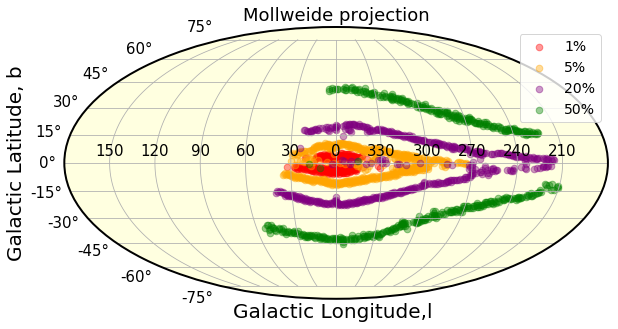

In [543]:
# Convert to Galactic coords ...
# Plot the same in Mollweide projection...
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide', axisbg ='LightYellow')

origin = 0

labels = ['1%','5%', '20%', '50%' ]
colors = ['red', 'orange', 'purple', 'green']
i = 0
for key in dic_radec.keys() : 
    c_high = SkyCoord(dic_radec[key]['ra'],dic_radec[key]['dec'], 
                      frame='icrs', unit='deg')
    RA = c_high.galactic.l.deg
    Dec  = c_high.galactic.b.deg
    
    
    # possibility to center the map on 0 or 180...
    x = np.remainder(RA+360-origin,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+origin,360)
    
    # plot 
    ax.scatter(np.radians(x),np.radians(Dec),  alpha=0.4,s=44,
               label= labels[i], color=colors[i])  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    i += 1 
    
title='Mollweide projection'
ax.set_title(title)
xlabel='Galactic Longitude,l '
ylabel='Galactic Latitude, b'
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.grid(True)
plt.legend(fontsize=14)
plt.savefig('Illustrate_density_regions_mollw_galactic.png', bbox_inches='tight')

### Find these ra, dec in DECam data from CTIO 4-m telescope ... 


We selected all imaging data that has:
* telescope = 'ct4m'
* instrument = 'decam'
* 90 sec < exposure < 125 sec 
* release_date < ‘2017-07-24'
* dec < 0 
* proctype = 'InstCal' 
* prodtype = 'image'
* filter is  u, g, r,  or VR 

(resulting in 11928 rows) 



In [535]:
# read in the results of VO table ... 
fname = '../rows_as_votable_1500933910_840.vot.xml'
from astropy.io.votable import parse_single_table
table = parse_single_table(fname)
decam = table.to_table()

0.01
0.06
0.21
0.51


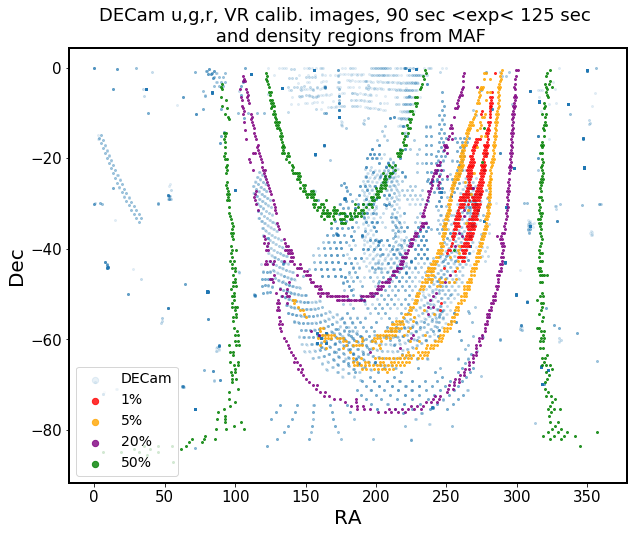

In [544]:
# Illustrate DECam regions in u,g,r, or VR filters fulfilling our criteria, 
# as a background to our counts ....

dotsize = 4
fig,ax = plt.subplots(1,1,figsize=(10,8))
plt.scatter(decam['ra'], decam['dec'], s=dotsize, alpha=0.1, label='DECam')
i =0
for key in dic_radec.keys() : 
    print(key)
    plt.scatter(dic_radec[key]['ra'], dic_radec[key]['dec'], alpha=0.8,s=dotsize,  
            label= labels[i], color=colors[i])
    i += 1 
    
legend = plt.legend(fontsize=14)
#lgnd = plt.legend(loc="lower left", numpoints=1, fontsize=10)

#change the marker size manually for both lines
for handle in legend.legendHandles : 
    handle._sizes = [40]
# awesome hack
# https://stackoverflow.com/questions/24706125/setting-a-fixed-size-for-points-in-legend
    
    
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('DECam u,g,r, VR calib. images, 90 sec <exp< 125 sec \n \
and density regions from MAF' )
plt.savefig('Illustrate_density_regions_DECam.png', bbox_inches='tight')   
    

In [465]:
# There are four density regimes...
keys = list(dic_radec.keys())
print(keys)

[0.01, 0.06, 0.21, 0.51]


In [490]:
# match the ra , dec in these decam data to the ra,dec of my regions ...
# first:  find top 1% regions : anything that is within 30 arcmin to the 1% regions .... 

# http://docs.astropy.org/en/stable/coordinates/matchsep.html 
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=dic_radec[keys[0]]['ra']*u.degree, 
             dec=dic_radec[keys[0]]['dec']*u.degree)  

catalog = SkyCoord(ra=decam['ra'].data.data*u.degree, 
                   dec=decam['dec'].data.data*u.degree)  
idx, d2d, d3d = c.match_to_catalog_sky(catalog)  

In [491]:
matches = catalog[idx]
decam_matches = decam[idx]

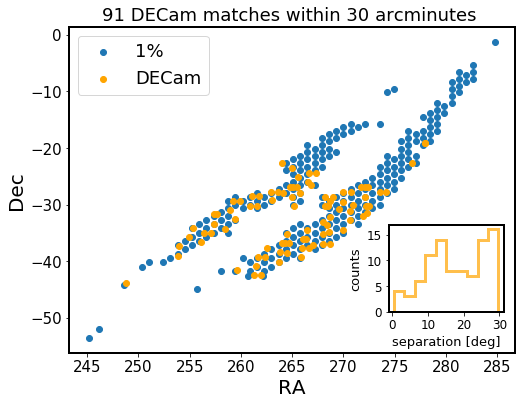

In [492]:
# Illustrate DECam matches to top 1% regions ...
fig,ax = plt.subplots(1,1,figsize=(8,6))
mask = d2d.deg < 0.5 # choose matches within 30 arcmin 
ax.scatter(dic_radec[keys[0]]['ra'], dic_radec[keys[0]]['dec'],
           label = labels[0])
ax.scatter(matches.ra.deg[mask], matches.dec.deg[mask], color='orange', label='DECam')
plt.legend(fontsize=18)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title(str(np.sum(mask))+' DECam matches within 30 arcminutes ')

# Add an inset histogram of separation ... 
ax1 = fig.add_axes([0.68,0.22,0.2,0.2])
ax1.hist(d2d.arcmin[mask], histtype='step', lw=3, alpha=0.7, color='orange')
ax1.tick_params(labelsize=12)
import matplotlib.ticker as ticker
tick_spacing=10
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
tick_spacing=5
ax1.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.set_ylabel('counts', fontsize=13)
ax1.set_xlabel('separation [deg]', fontsize=13)
plt.savefig('Illustrate_top_1_perc_DECam_matches.png', bbox_inches='tight')

In [437]:
#dic_radec[keys[0]]

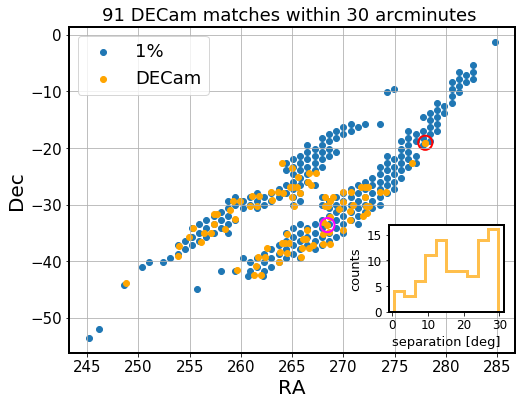

In [493]:
# Select a pixel that is close to center of the density region ...

# c4d_140624_081148_ooi_r_v2.fits.fz 
ra_sel = 277.98111299999999
dec_sel = -19.083333

# 

# Illustrate DECam matches to top 1% regions ...
fig,ax = plt.subplots(1,1,figsize=(8,6))
mask = d2d.deg < 0.5 # choose matches within 30 arcmin 
ax.scatter(dic_radec[keys[0]]['ra'], dic_radec[keys[0]]['dec'],
           label = labels[0])
ax.scatter(matches.ra.deg[mask], matches.dec.deg[mask], color='orange', label='DECam')
ax.scatter(ra_sel, dec_sel, s=200, facecolors='none', edgecolors='r', lw=2)

# Select one pixel that is surrounded by other high-density pixels ...
decam_ra = decam_maf['ra'].data.data
decam_dec = decam_maf['dec'].data.data

mask_ra = (267<decam_ra) * (decam_ra<270)
mask_dec  = (-41<decam_dec)*(decam_dec < -31)
mask_radec = mask_ra * mask_dec

# c4d_170428_094150_ooi_g_v1.fits.fz 
ra_sel1 = decam_maf[mask_radec]['ra'][2]
dec_sel1 = decam_maf[mask_radec]['dec'][2]
ax.scatter(ra_sel1, dec_sel1, s=200, facecolors='none', edgecolors='magenta', lw=2)

plt.legend(fontsize=18)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title(str(np.sum(mask))+' DECam matches within 30 arcminutes ')
ax.grid()
# Add an inset histogram of separation ... 
ax1 = fig.add_axes([0.68,0.22,0.2,0.2])
ax1.hist(d2d.arcmin[mask], histtype='step', lw=3, alpha=0.7, color='orange')
ax1.tick_params(labelsize=12)
import matplotlib.ticker as ticker
tick_spacing=10
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
tick_spacing=5
ax1.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.set_ylabel('counts', fontsize=13)
ax1.set_xlabel('separation [deg]', fontsize=13)
plt.savefig('Illustrate_top_1_perc_DECam_matches_choice.png', bbox_inches='tight')

### Stack the MAF info with DECam data 

In [500]:
# make info about those pixels that have a DECam match into a table...
# then vstack that table against DECam table ... 
from astropy.table import Column
from astropy.table import Table

attributes = list(dic_radec[keys[0]].keys())
# initialize Table
t  = Table()
# loop over dictionary making cols and adding to Table 

for key in attributes : 
    col = Column(dic_radec[keys[0]][key][mask], name = 'MAF_' + key)
    t.add_column(col)


In [501]:
from astropy.table import hstack
decam_maf = hstack([decam_matches[mask], t])

# I save this table,  for future reference ... 
fname = 'table_decam_maf_matched_'+str(keys[0])+'_density_percent.csv'
decam_maf.write(fname, overwrite=True)

In [502]:
decam_maf

reference,dtpropid,surveyid,release_date,start_date,date_obs,dtpi,ra,dec,telescope,instrument,filter,exposure,obstype,obsmode,proctype,prodtype,seeing,depth,dtacqnam,archive_file,filesize,md5sum,MAF_ra,MAF_dec,MAF_N_px_gt_density,MAF_px_density,MAF_healpix
object,object,object,object,object,object,object,float64,float64,object,object,object,float64,object,object,object,object,float64,float64,object,object,int32,object,float64,float64,int64,float64,int64
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_140624_081148_ooi_r_v2.fits.fz,2014A-0612,,2015-12-24,2014-06-23,2014-06-24 08:09:15.32,Geisler,277.98111299999999,-19.083333,ct4m,decam,r DECam SDSS c0002 6415.0 1480.0,100.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2014A-0612/DECam_00329248.fits.fz,c4d_140624_081148_ooi_r_v2.fits.fz,350956800,52670fbf13adcbc8214f1815be2a1ad4,278.4375,-18.8394045473,243,2590488.0,32582
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_140624_080728_ooi_r_v1.fits.fz,2014A-0612,,2015-12-24,2014-06-23,2014-06-24 08:04:58.395,Geisler,277.943625,-19.120971999999998,ct4m,decam,r DECam SDSS c0002 6415.0 1480.0,100.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2014A-0612/DECam_00329246.fits.fz,c4d_140624_080728_ooi_r_v1.fits.fz,346605120,a7ee540ef85ea473a41172cebf5ca6c4,277.734375,-19.4712206345,238,2650680.0,32837
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170504_084722_ooi_g_v1.fits.fz,2016B-0279,,2017-05-02,2017-05-03,2017-05-04 08:44:57.907,Finkbeiner,264.04304200000001,-22.608889000000001,ct4m,decam,g DECam SDSS c0001 4720.0 1520.0,96.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2016B-0279/DECam_00647107.fits.fz,c4d_170504_084722_ooi_g_v1.fits.fz,343258560,56283ce226e0a743270e395f67e84e41,264.375,-22.6696098718,202,2833740.0,34108
http://nsaserver.sdm.noao.edu:7003/?fileRef=tu1839100.fits.fz,2013A-0719,,2013-08-04,2013-08-05,2013-08-06 03:00:13.525,Saha,276.68537500000002,-22.656806,ct4m,decam,r DECam SDSS c0002 6415.0 1480.0,100.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2013A-0719/DECam_00223878.fits.fz,tu1839100.fits.fz,394136640,9d666e233019ab6918e24206eb298f9f,277.03125,-22.6696098718,237,2655360.0,34117
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170430_091501_ooi_g_v1.fits.fz,2016B-0279,,2017-04-28,2017-04-29,2017-04-30 09:12:36.149,Finkbeiner,265.00570800000003,-23.478221999999999,ct4m,decam,g DECam SDSS c0001 4720.0 1520.0,96.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2016B-0279/DECam_00645422.fits.fz,c4d_170430_091501_ooi_g_v1.fits.fz,343448640,f8ba7699b7ad0a40e5cfb44bbcba6a96,265.078125,-23.3179570653,94,4006080.0,34364
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170429_092413_ooi_g_v1.fits.fz,2016B-0279,,2017-04-27,2017-04-28,2017-04-29 09:21:49.45,Finkbeiner,267.28083299999997,-24.364028000000001,ct4m,decam,g DECam SDSS c0001 4720.0 1520.0,96.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2016B-0279/DECam_00644912.fits.fz,c4d_170429_092413_ooi_g_v1.fits.fz,334546560,ed60645bf07ed3b58e671fcb3fd748c5,267.1875,-23.9694823178,45,4868100.0,34622
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170430_091907_ooi_g_v1.fits.fz,2016B-0279,,2017-04-28,2017-04-29,2017-04-30 09:16:39.382,Finkbeiner,266.635625,-24.356110999999999,ct4m,decam,g DECam SDSS c0001 4720.0 1520.0,96.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2016B-0279/DECam_00645425.fits.fz,c4d_170430_091907_ooi_g_v1.fits.fz,339413760,4ba689abdba6922ce378421320739406,266.484375,-24.6243183522,159,3153852.0,34877
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170429_092209_ooi_g_v1.fits.fz,2016B-0279,,2017-04-27,2017-04-28,2017-04-29 09:19:44.497,Finkbeiner,265.544917,-25.204277999999999,ct4m,decam,g DECam SDSS c0001 4720.0 1520.0,96.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2016B-0279/DECam_00644911.fits.fz,c4d_170429_092209_ooi_g_v1.fits.fz,330540480,430fda20688832cbb02ab13121c65e65,265.78125,-25.2826030433,23,5766408.0,35133
http://nsaserver.sdm.noao

In [377]:
np.ravel(decam_maf.colnames)

array(['reference', 'dtpropid', 'surveyid', 'release_date', 'start_date',
       'date_obs', 'dtpi', 'ra', 'dec', 'telescope', 'instrument',
       'filter', 'exposure', 'obstype', 'obsmode', 'proctype', 'prodtype',
       'seeing', 'depth', 'dtacqnam', 'archive_file', 'filesize', 'md5sum',
       'MAF_ra', 'MAF_dec', 'MAF_N_px_gt_density', 'MAF_px_density'], 
      dtype='<U19')

In [393]:
decam_maf[['ra', 'MAF_ra', 'dec', 'MAF_dec',  'filter', 'exposure', 
           'archive_file', 'MAF_px_density']]

ra,MAF_ra,dec,MAF_dec,filter,exposure,archive_file,MAF_px_density
float64,float64,float64,float64,object,float64,object,float64
268.18141700000001,267.890625,-30.312138999999998,-30.0,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170430_090232_ooi_g_v1.fits.fz,146670660.0
268.65912500000002,268.59375,-29.352582999999999,-29.3131989642,g DECam SDSS c0001 4720.0 1520.0,120.0,c4d_140510_092346_ooi_g_v1.fits.fz,143440164.0
269.0,269.296875,-28.699999999999999,-28.6309898369,g DECam SDSS c0001 4720.0 1520.0,120.0,c4d_150718_234407_ooi_g_v1.fits.fz,112073040.0
269.99824999999998,270.0,-29.480667,-29.3131989642,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170430_094538_ooi_g_v1.fits.fz,95910768.0
270.88249999999999,270.703125,-30.037555999999999,-30.0,g DECam SDSS c0001 4720.0 1520.0,100.0,tu1906259.fits.fz,87035400.0
270.001667,270.0,-27.795306,-27.9531868834,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170430_093931_ooi_g_v1.fits.fz,84478284.0
265.20054199999998,265.078125,-30.273194,-30.0,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170429_074522_ooi_g_v1.fits.fz,83388852.0
268.51862499999999,268.59375,-30.310611000000002,-30.6915876849,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170428_094758_ooi_g_v1.fits.fz,81637704.0
264.12537500000002,264.375,-27.926805999999999,-27.9531868834,g DECam SDSS c0001 4720.0 1520.0,120.0,c4d_140511_095516_ooi_g_v1.fits.fz,80595504.0


In [503]:
archive_names = np.array(decam_maf['archive_file'].data.data).astype(str)
mask = archive_names == 'c4d_140624_081148_ooi_r_v2.fits.fz'
np.sum(mask)
decam_maf[mask]

reference,dtpropid,surveyid,release_date,start_date,date_obs,dtpi,ra,dec,telescope,instrument,filter,exposure,obstype,obsmode,proctype,prodtype,seeing,depth,dtacqnam,archive_file,filesize,md5sum,MAF_ra,MAF_dec,MAF_N_px_gt_density,MAF_px_density,MAF_healpix
object,object,object,object,object,object,object,float64,float64,object,object,object,float64,object,object,object,object,float64,float64,object,object,int32,object,float64,float64,int64,float64,int64
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_140624_081148_ooi_r_v2.fits.fz,2014A-0612,,2015-12-24,2014-06-23,2014-06-24 08:09:15.32,Geisler,277.98111299999999,-19.083333,ct4m,decam,r DECam SDSS c0002 6415.0 1480.0,100.0,object,imaging,InstCal,image,--,--,/data_local/images/DTS/2014A-0612/DECam_00329248.fits.fz,c4d_140624_081148_ooi_r_v2.fits.fz,350956800,52670fbf13adcbc8214f1815be2a1ad4,278.4375,-18.8394045473,243,2590488.0,32582


In [384]:
# I pull one of these files, searching by archive filename 
# c4d_140624_081148_ooi_r_v2.fits.fz 
# Here the theoretical  density is 2.59 mln sources per sq. degree. 
# we found 

# I also take another one, which has DECam ra,dec  surrounded by other high-density pixels :
# c4d_170428_094150_ooi_g_v1.fits.fz
# Here the theoretical density is 4.58 mln sources per sq degree 
# we found 417 thousand, 



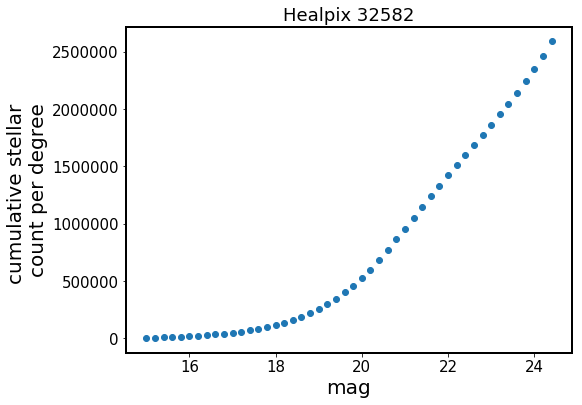

In [516]:
# plot that healpixel count : 

healpix  = 32582
# Confirm that the data along magnitude bins is indeed cumulative ... 
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter( bins[bright_mags], data['starDensity'][:,bright_mags][healpix])
ax.set_xlabel('mag')
ax.set_ylabel('cumulative stellar \ncount per degree')
ax.set_title('Healpix '+str(healpix))
plt.savefig('Illustrate_count_pixel_'+str(healpix)+'.png', bbox_inches='tight')
#np.shape(data['starDensity'][:, bright_mags])

In [120]:
# http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html 
# based on code by Eduardo Martín Calleja  
def plot_mwd(RA,Dec,origin=0, xlabel = 'RA', ylabel = 'Dec',
             title='Mollweide projection', projection='mollweide', ax = None):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    # possibility to center the map on 0 or 180...
    x = np.remainder(RA+360-origin,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+origin,360)
    
    # starting the plotting area 
    if ax is None:  
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection=projection, axisbg ='LightYellow')
    ax.scatter(np.radians(x),np.radians(Dec))  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


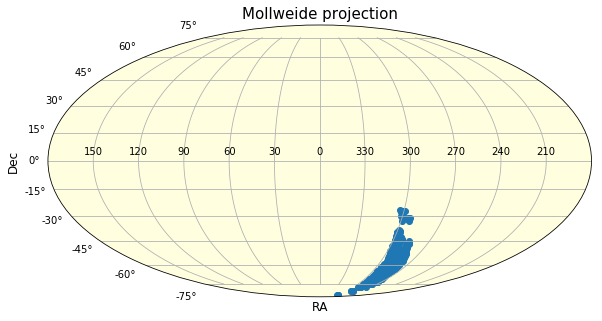

In [87]:
# Now plot the same in galactic coords ... 
# http://docs.astropy.org/en/stable/coordinates/ 
from astropy.coordinates import SkyCoord
c_high = SkyCoord(ra_top_perc,dec_top_perc, frame='icrs', unit='deg')
# plot in equatorial coords, mollweide projection,
# only bright pixels 
plot_mwd(c_high.icrs.ra.deg, c_high.icrs.dec.deg)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


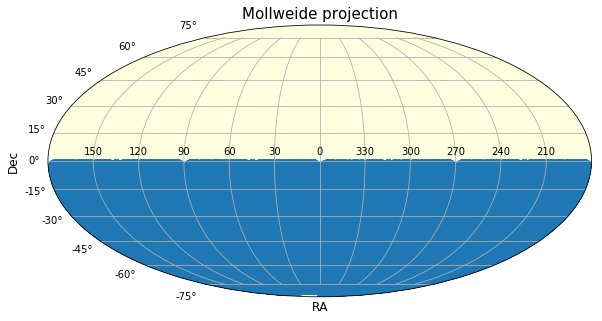

In [88]:
# Plot in Mollweide all southern pixels...
c_all = SkyCoord(ra_sel,dec_sel, frame='icrs', unit='deg')
plot_mwd(c_all.icrs.ra.deg, c_all.icrs.dec.deg)

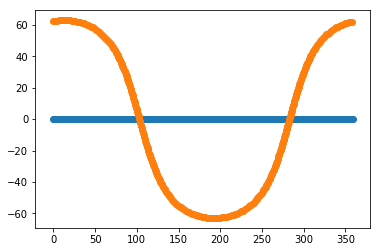

In [89]:
# In  Galactic coordinates,  galaxy lies all around in longitude, 
# at zero latitude
lon = np.arange(0,360)
lat = np.zeros_like(lon)

c_gal = SkyCoord(lon,lat, frame='galactic', unit='deg')

# Both coordinate systems go  in  
# longitude ,  or right ascenscion,  from  0 to 360 degrees,
# latitude, or declination, from -90 to +90.... 

# plot in Galactic coords 
plt.scatter(c_gal.l, c_gal.b)

# plot in Equatorial coords 
plt.scatter(c_gal.icrs.ra, c_gal.icrs.dec)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


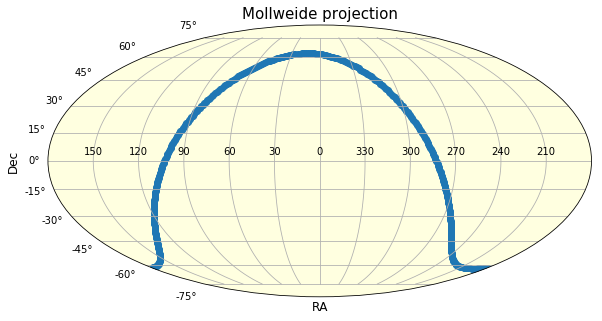

In [90]:
# Plot the same in Mollweide projection...
plot_mwd(c_gal.icrs.ra.deg, c_gal.icrs.dec.deg)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


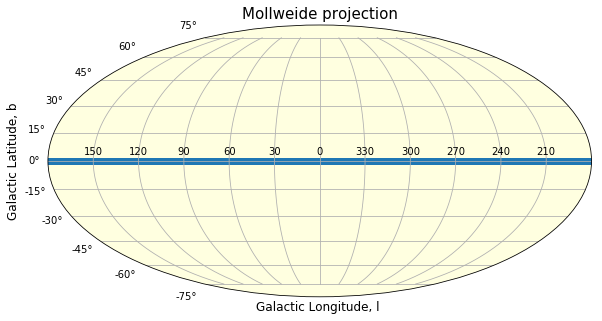

In [91]:
# Plot the same in Mollweide projection...
# As we'd expect, the Galaxy IS along the Latitude  = 0    
plot_mwd(c_gal.l.deg, c_gal.b.deg, xlabel='Galactic Longitude, l ', 
         ylabel='Galactic Latitude, b')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


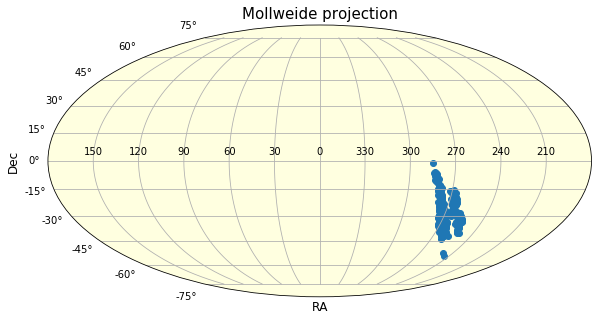

In [180]:
c_high = SkyCoord(ra_top_perc,dec_top_perc, frame='icrs', unit='deg')

# Plot in Equatorial coords,  Mollweide projection
plot_mwd(c_high.icrs.ra.deg, c_high.icrs.dec.deg)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


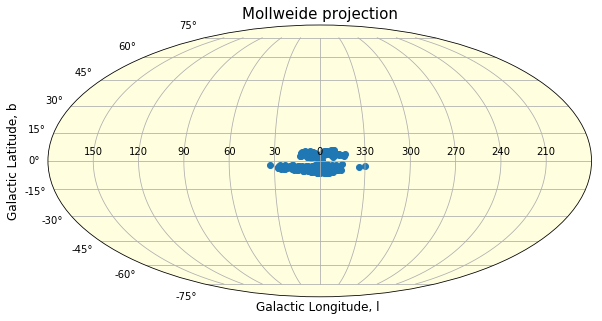

In [181]:
# Plot in Galactic coords, Mollweide projection
plot_mwd(c_high.galactic.l.deg, c_high.galactic.b.deg,
         xlabel='Galactic Longitude, l ', 
         ylabel='Galactic Latitude, b')

The high-density regions are close to galactic plane, as we would expect ... 

In [188]:
# Print the list of ra, dec in degrees for each density regime : 

# top 1% : beetween  0 and 1 %  
# 5% : between 4-6 % 
# 20 % : between 19-21 % 
# 50 % : between 49-51 %
for key in dic_radec.keys() :
    print('\n')
    print(key)
    for ra, dec in zip(dic_radec[key]['ra'][:10], dic_radec[key]['dec'][:10]):
        print('%.6f, %.6f'%(ra,dec))



0.01
284.765625, -1.193748
283.359375, -5.979157
282.656250, -6.579593
284.062500, -6.579593
281.953125, -7.180756
283.359375, -7.180756
282.656250, -7.782714
281.953125, -8.385539
283.359375, -8.385539
281.250000, -8.989299


0.06
289.687500, -0.596842
288.984375, -1.193748
290.390625, -1.193748
277.031250, -1.790785
278.437500, -1.790785
279.843750, -1.790785
289.687500, -1.790785
283.359375, -2.388015
288.984375, -2.388015
278.437500, -2.985506


0.21
105.468750, -0.596842
300.937500, -0.596842
262.265625, -1.193748
300.234375, -1.193748
261.562500, -1.790785
299.531250, -1.790785
106.171875, -2.388015
298.828125, -2.388015
105.468750, -2.985506
106.875000, -2.985506


0.51
234.843750, -0.596842
121.640625, -1.193748
321.328125, -1.193748
88.593750, -1.790785
120.937500, -1.790785
122.343750, -1.790785
320.625000, -1.790785
234.140625, -2.388015
319.921875, -2.388015
122.343750, -2.985506


In [182]:
dic_radec.keys() 

dict_keys([0.01, 0.06, 0.21, 0.51])

Now we characterize the stellar density by calculating what fraction of the sky is at or above a given density ... 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10


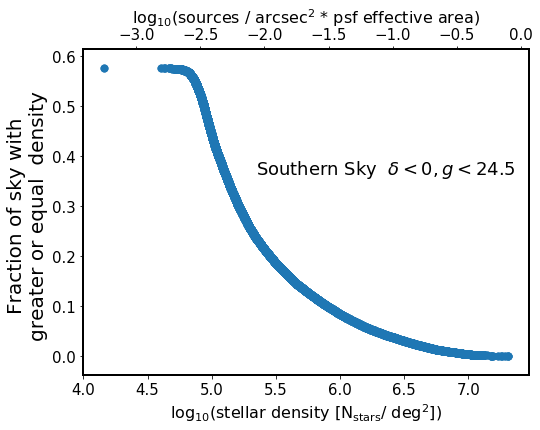

In [125]:
# Instead of making two plots, make one plot , with two x-axes...
%matplotlib inline
# Generic plot settings...
import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20

N_pixels = len(density_dic['px_density'])

fig,ax1 = plt.subplots(1,1,figsize=(8,6))
ax1.scatter(np.log10(density_dic['px_density']), 
           np.array(density_dic['N_gt_px']) / N_pixels, lw=2)

ax1.set_xlabel(r'$\log_{10}$'+'(stellar density [N'+
               r'$_{\mathrm{stars}}$'+'/ deg'+r'$^{2}$'+'])', 
                 fontsize=16)

ax1.set_ylabel('Fraction of sky with \ngreater or equal  density ')
fig.text(0.65,0.59, 'Southern Sky  '+r'$\delta < 0, g < 24.5$',
         horizontalalignment='center', fontsize=18 )


density_dimless = (np.array(density_dic['px_density']) / (3600*3600) )* np.pi * 0.4*0.4
ax2 = ax1.twiny()

ax2.scatter(np.log10(density_dimless), 
           np.array(density_dic['N_gt_px']) / N_pixels, lw=2)
ax2.set_xlabel(r'$\log_{10}$'+'(sources / arcsec'+r'$^{2}$'+' * psf effective area)', 
                 fontsize=16)

plt.savefig('Southern_sky_g_lt24.5_twiny.png')